[0.88533933 1.00811567]


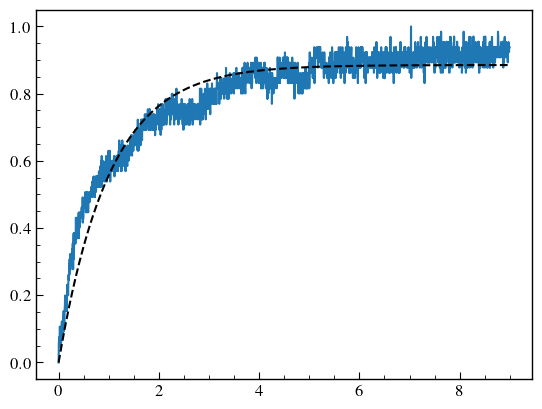

In [41]:
from AnalyzeMot import AnalyzeMOT
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
sys.path.append('../')
import mp1_config

path = "./Data/Gradient/"
files = sorted([os.path.join(path, file) for file in os.listdir(path)])

def strip_file_name(file_name: str) : 
    return int(file_name.split(sep='_')[-1].split('.csv')[0])

def get_gradient(file_name: str) : 
    global files 
    number = strip_file_name(file_name)
    first_number = strip_file_name(files[0])
    gradient = (3.5 - 0.3*(number - first_number))
    return gradient

def remove_trigger(time: np.array, signal:  np.array) : 
    mask = time >= 0
    return (time[mask], signal[mask])

def load_data(file: str) : 
    data = np.loadtxt(file, skiprows=2, delimiter=',')
    time, signal = remove_trigger(data[:,0], data[:,1])
    signal = signal - signal[0]
    signal = signal / max(signal)

    return time, signal

def exponential(t, *ps) : 
    A, tau = ps[0], ps[1]
    return A*(1-np.exp(-t/tau))

def fit_exponential(time, signal) : 
    A0 = max(signal) - min(signal)
    tau0 = (time.max() - time.min())/3

    popt, pcov = curve_fit(exponential, xdata=time, ydata=signal, p0=[A0, tau0])
    return (popt, pcov)

def plot_fit(ax, popt, pcov, time, signal) :    
    t_fit = np.linspace(min(time), max(time), 10000)
    s_fit = exponential(t_fit, *popt)
    ax.plot(t_fit, s_fit, 'k--', label='Fit')

time, signal = load_data(files[0])

popt, pcov = fit_exponential(time, signal)
print(popt)

fig, ax = plt.subplots()

ax.plot(time, signal)
plot_fit(ax, popt, pcov, time, signal)